# 03_Modelading

## Equipo 1

### Librerías necesarias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,roc_curve, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression
import joblib
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, matthews_corrcoef, balanced_accuracy_score, confusion_matrix, classification_report, brier_score_loss, make_scorer
from sklearn.calibration import calibration_curve
from sklearn.manifold import TSNE
import time
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import f_oneway
from math import pi

warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Cargar datos

In [2]:
df = pd.read_csv('../data/processed.csv')
df_num = df.select_dtypes(include=['int64', 'float64'])
X_train,X_test,y_train,y_test=train_test_split(df_num.drop(columns='Survived'),df['Survived'],test_size=0.2,random_state=42,stratify=df['Survived'])

## Protocolo de Experimentación

In [7]:
class ModelExperiment:
    def __init__(self, model_name, model, param_grid, scoring='f1', random_state=42,refit_metric='f1'):
        self.model_name = model_name
        self.model = model
        self.param_grid = param_grid
        self.random_state = random_state
        self.results = {}
        self.best_estimator_ = None
        self.scoring = scoring
        self.refit_metric = refit_metric

    def run_experiment(self, X_train, y_train, X_test, y_test, cv_splits=5):
        print(f"=== {self.model_name} ===")

        # 1. GridSearch con validación cruzada estratificada
        cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=self.random_state)
        grid = GridSearchCV(
            estimator=self.model,
            param_grid=self.param_grid,
            scoring=self.scoring,
            cv=cv,
            n_jobs=-1,
            verbose=1,
            refit=self.refit_metric
        )
        grid.fit(X_train, y_train)
        self.best_estimator_ = grid.best_estimator_

        # 2. Evaluación en conjunto de validación
        y_pred = self.best_estimator_.predict(X_test)
        y_proba = self.best_estimator_.predict_proba(X_test)[:, 1] if hasattr(self.best_estimator_, "predict_proba") else None

        # 3. Guardar resultados
        self.results['best_params'] = grid.best_params_
        self.results['classification_report'] = classification_report(y_test, y_pred, output_dict=True)
        self.results['confusion_matrix'] = confusion_matrix(y_test, y_pred)
        self.results['roc_auc'] = roc_auc_score(y_test, y_proba) if y_proba is not None else None

        # 4. Persistencia del modelo
        joblib.dump(self.best_estimator_, f"../models/{self.model_name}_final.pkl")

        return self.results

## Regresión Logística

In [4]:
drop_svm = [
    # Identificadores y texto

    # Variables categóricas originales
    'Pclass',

    # Codificación redundante (label/ordinal)
    'Sex_LE','Embarked_LE','Deck_LE','TitleGroup_LE','AgeGroup_LE',
    'Pclass_ordinal','AgeGroup_ordinal','FareLevel_ordinal',

    # Dummies de referencia (una por grupo para evitar colinealidad)
    'Sex_male',          # dejamos solo Sex_female
    'Pclass_3',          # dejamos Pclass_1 y Pclass_2
    'Embarked_S',        # dejamos C, Q, O
    'TitleGroup_Common', # dejamos Military, Noble, Professional
    'AgeGroup_Adulto',   # dejamos Niño, Adolescente, Adulto Joven, Mayor
    'FareLevel_Medio',   # dejamos Muy bajo, Bajo, Alto, Muy alto
    'Deck_UK'            # dejamos A, B, C, D, E, F, G, T
]

X = df_num.drop(columns=drop_svm + ['Survived'])
y = df['Survived']

X_train_svm,X_test_svm,y_train_svm,y_test_svm=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [5]:
log_reg_exp = ModelExperiment(
    model_name="LogisticRegression",
    model=LogisticRegression(max_iter=1000, solver='saga'),
    param_grid={
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['saga','liblinear', 'lbfgs', 'newton-cg', 'sag'],
        'class_weight': [None, 'balanced', {0:1, 1:2}, {0:1, 1:3}],
        'max_iter': [500, 1000, 2000]
    }
)

In [8]:
resultados_log=log_reg_exp.run_experiment(X_train_svm, y_train_svm, X_test_svm, y_test_svm)

=== LogisticRegression ===
Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


c:\Users\ivanl\OneDrive\Documentos\dataFootIL\.conda\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
4680 fits failed out of a total of 7200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ivanl\OneDrive\Documentos\dataFootIL\.conda\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ivanl\OneDrive\Documentos\dataFootIL\.conda\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ivanl\OneDriv

### Mejores parámetros

In [9]:
logmodel = joblib.load('../models/LogisticRegression_final.pkl')
print(logmodel)

LogisticRegression(C=100, class_weight='balanced', max_iter=500, penalty='l1',
                   solver='liblinear')


### Evaluación

### Métricas Básicas

In [10]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Calcula todas las métricas requeridas
    """
    metrics=[]

    ti_tr = time.time()
    model.fit(X_train, y_train)
    tf_tr = time.time()
    t_tr = tf_tr - ti_tr

    ti_inf = time.time()
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1]
    tf_inf = time.time()
    t_inf = tf_inf - ti_inf

    metrics.append({
        #"Modelo": ,
        "Accuracy": accuracy_score(y_test, predictions),
        "Precision": precision_score(y_test, predictions, zero_division=0),
        "Recall": recall_score(y_test, predictions, zero_division=0),
        "F1-Score": f1_score(y_test, predictions, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, probabilities),
        "PR-AUC": average_precision_score(y_test, probabilities),
        "MCC": matthews_corrcoef(y_test, predictions),
        "Balanced Accuracy": balanced_accuracy_score(y_test, predictions)
    })
        
    return pd.DataFrame(metrics), predictions, probabilities, t_tr, t_inf

In [11]:
log_best = joblib.load('../models/LogisticRegression_final.pkl')

metrics_log, y_pred, y_proba, t_tr_log, t_inf_log = evaluate_model(log_best, X_train_svm, y_train_svm, X_test_svm, y_test_svm)

metrics_log.T

,0
Accuracy,0.798883
Precision,0.708861
Recall,0.811594
F1-Score,0.756757
ROC-AUC,0.863900
PR-AUC,0.790420
MCC,0.590564
Balanced Accuracy,0.801252


### Métricas por Clase/Grupo

### Confusion Matrix

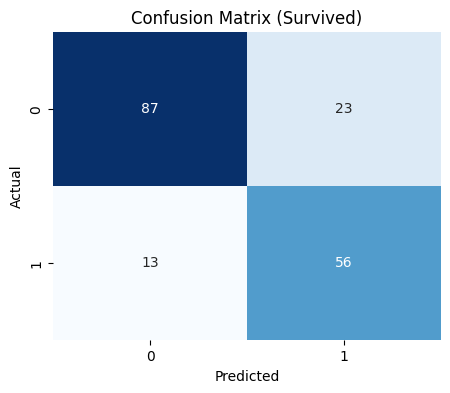

In [12]:
cm = confusion_matrix(y_test_svm, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Survived)')
plt.show()

### Métricas desagregadas por:

In [13]:
#función de métricas por grupo
def metrics_by_group(y_true, y_pred, y_proba, group):
    results = []
    for g in np.unique(group.dropna()):
        mask = (group == g)
        yt, yp = y_true[mask], y_pred[mask]
        ytr, ypr = y_true[mask], y_proba[mask]
        if len(np.unique(yt)) == 1:  #evita errores si solo hay una clase
            continue
        results.append({
            "Grupo": g,
            "Accuracy": accuracy_score(yt, yp),
            "Precision": precision_score(yt, yp, zero_division=0),
            "Recall": recall_score(yt, yp, zero_division=0),
            "F1-Score": f1_score(yt, yp, zero_division=0),
            "ROC-AUC": roc_auc_score(ytr, ypr),
            "PR-AUC": average_precision_score(ytr, ypr),
            "MCC": matthews_corrcoef(yt, yp),
            "Balanced Accuracy": balanced_accuracy_score(yt, yp)
        })
    return pd.DataFrame(results)

Género

In [14]:
print("Métricas por Género\n(Hombre=0, Mujer=1)")
metrics_by_group(y_test_svm, y_pred, y_proba, X_test_svm['Sex_female'])

Métricas por Género
(Hombre=0, Mujer=1)


,Grupo,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,MCC,Balanced Accuracy
0,0,0.796610,0.500000,0.458333,0.478261,0.750443,0.484397,0.352756,0.670656
1,1,0.803279,0.789474,1.000000,0.882353,0.773611,0.865184,0.444262,0.625000


Clase Socioeconómica

In [15]:
print("Métricas por Clase Socioeconómica")
metrics_by_group(y_test_svm, y_pred, y_proba, X_test['Pclass'])

Métricas por Clase Socioeconómica


,Grupo,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,MCC,Balanced Accuracy
0,1,0.644444,0.645161,0.80,0.714286,0.776000,0.789940,0.268337,0.625000
1,2,0.911765,0.947368,0.90,0.923077,0.910714,0.927293,0.821271,0.914286
2,3,0.830000,0.620690,0.75,0.679245,0.805373,0.573584,0.569677,0.802632


Grupo de Edad

In [16]:
print("Métricas por Grupo de Edad")
metrics_by_group(y_test_svm, y_pred, y_proba, X_test['AgeGroup_ordinal'])

Métricas por Grupo de Edad


,Grupo,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,MCC,Balanced Accuracy
0,1,0.785714,0.727273,1.00000,0.842105,0.645833,0.662784,0.603023,0.750000
1,2,0.833333,0.733333,1.00000,0.846154,0.930070,0.915998,0.712525,0.846154
2,3,0.819048,0.763158,0.74359,0.753247,0.853147,0.826283,0.610556,0.803613
3,4,0.709677,0.538462,0.70000,0.608696,0.819048,0.771669,0.392466,0.707143
4,5,0.800000,0.500000,1.00000,0.666667,1.000000,1.000000,0.612372,0.875000


Tamaño de familia

In [17]:
print("Métricas por Tamaño de Familia\n")
metrics_by_group(y_test_svm, y_pred, y_proba, X_test_svm['FamilySize'])

Métricas por Tamaño de Familia



,Grupo,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,MCC,Balanced Accuracy
0,-0.791007,0.805825,0.709677,0.666667,0.687500,0.821645,0.753980,0.547417,0.769048
1,0.836696,0.812500,0.800000,0.888889,0.842105,0.916667,0.941460,0.618070,0.801587
2,1.343027,0.720000,0.611111,1.000000,0.758621,0.811688,0.783882,0.552771,0.750000
3,1.558215,0.857143,0.833333,1.000000,0.909091,0.500000,0.710000,0.645497,0.750000
4,1.729856,0.666667,0.500000,1.000000,0.666667,1.000000,1.000000,0.500000,0.750000


### Análisis de Calibración

### Calibration plots (reliability diagrams)

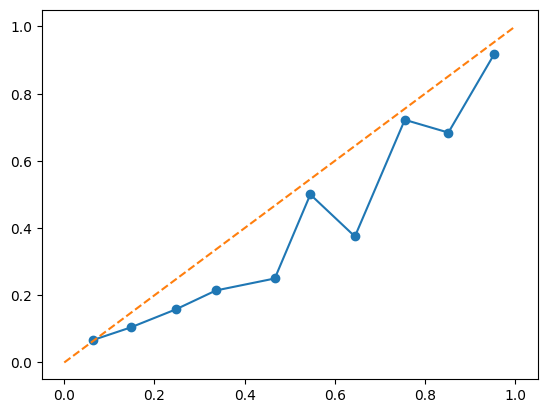

In [18]:
prob_true, prob_pred = calibration_curve(y_test_svm, y_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1], linestyle='--')
plt.show()

### Brier Score

In [19]:
brier_score_loss(y_test_svm, y_proba)

0.14706470630318053

### Expected Calibration Error (ECE)

In [20]:
print(np.abs(prob_true - prob_pred).mean())

0.10263673214338231


## Random Forest

In [21]:
drop_tree = ['PassengerId',
             'Sex_LE','Embarked_LE','Deck_LE','TitleGroup_LE',
             'Pclass_ordinal','Deck_UK','Parch']
X = df_num.drop(columns=drop_tree + ['Survived'])
y = df['Survived']

X_train_tree,X_test_tree,y_train_tree,y_test_tree=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [22]:
rf_exp = ModelExperiment(
    model_name="RandomForest",
    model=RandomForestClassifier(random_state=42),
    param_grid={
        'n_estimators': [20,50,100,200,300],
        'max_depth': [3,5,10,20,50,None],
        'min_samples_split': [2,3,4,5,10],
        'min_samples_leaf': [1, 2, 3],
        'max_features': ['sqrt', 'log2'],
        'class_weight': ['balanced','balanced_subsample']
    },
    scoring={'f1':'f1','roc_auc':'roc_auc','recall':'recall'},
    refit_metric='recall'
)

In [23]:
results = rf_exp.run_experiment(X_train_tree, y_train_tree, X_test_tree, y_test_tree)

=== RandomForest ===
Fitting 5 folds for each of 1800 candidates, totalling 9000 fits


### Mejores parámetros

In [24]:
rfmodel = joblib.load('../models/RandomForest_final.pkl')
print(rfmodel)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features='log2', min_samples_leaf=3,
                       min_samples_split=10, n_estimators=200, random_state=42)


### Evaluación
### Métricas básicas

In [25]:
rf_best = joblib.load('../models/RandomForest_final.pkl')

metrics_rf, y_pred, y_proba, t_tr_rf, t_inf_rf = evaluate_model(rf_best, X_train_tree, y_train_tree, X_test_tree, y_test_tree)

metrics_rf.T

,0
Accuracy,0.810056
Precision,0.727273
Recall,0.811594
F1-Score,0.767123
ROC-AUC,0.862187
PR-AUC,0.832137
MCC,0.610164
Balanced Accuracy,0.810343


### Métricas por Clase/Grupo

### Confusion Matrix

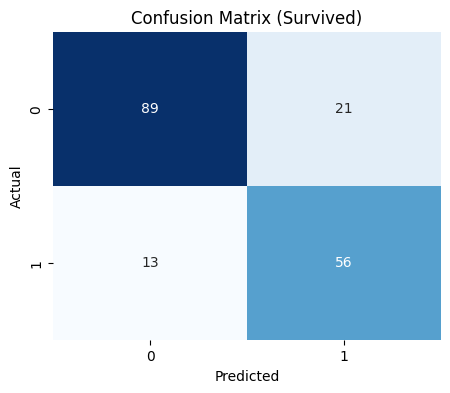

In [26]:
cm = confusion_matrix(y_test_tree, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Survived)')
plt.show()

### Métricas desagregadas por:

Género

In [27]:
print("Métricas por Género\n(Hombre=0, Mujer=1)")
metrics_by_group(y_test_tree, y_pred, y_proba, X_test_tree['Sex_female'])

Métricas por Género
(Hombre=0, Mujer=1)


,Grupo,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,MCC,Balanced Accuracy
0,0,0.796610,0.500000,0.500000,0.500000,0.718085,0.550813,0.372340,0.686170
1,1,0.836066,0.830189,0.977778,0.897959,0.840278,0.923615,0.541155,0.707639


Clase socioeconómica

In [28]:
print("Métricas por Clase Socioeconómica")
metrics_by_group(y_test_tree, y_pred, y_proba, X_test['Pclass'])

Métricas por Clase Socioeconómica


,Grupo,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,MCC,Balanced Accuracy
0,1,0.666667,0.656250,0.840000,0.736842,0.782000,0.851357,0.317934,0.645000
1,2,0.911765,0.947368,0.900000,0.923077,0.914286,0.944506,0.821271,0.914286
2,3,0.840000,0.653846,0.708333,0.680000,0.781250,0.648465,0.574377,0.794956


Grupo de Edad

In [29]:
print("Métricas por Grupo de Edad")
metrics_by_group(y_test_tree, y_pred, y_proba, X_test['AgeGroup_ordinal'])

Métricas por Grupo de Edad


,Grupo,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,MCC,Balanced Accuracy
0,1,0.857143,0.800000,1.000000,0.888889,0.854167,0.833879,0.730297,0.833333
1,2,0.833333,0.769231,0.909091,0.833333,0.951049,0.941699,0.678322,0.839161
2,3,0.819048,0.763158,0.743590,0.753247,0.833333,0.819190,0.610556,0.803613
3,4,0.709677,0.533333,0.800000,0.640000,0.857143,0.823180,0.436527,0.733333
4,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Tamaño de familia

In [30]:
print("Métricas por Tamaño de Familia")
metrics_by_group(y_test_tree, y_pred, y_proba, X_test_tree['FamilySize'])

Métricas por Tamaño de Familia


,Grupo,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,MCC,Balanced Accuracy
0,-0.791007,0.805825,0.709677,0.666667,0.687500,0.805195,0.774141,0.547417,0.769048
1,0.836696,0.781250,0.761905,0.888889,0.820513,0.888889,0.922401,0.555391,0.765873
2,1.343027,0.800000,0.687500,1.000000,0.814815,0.961039,0.963326,0.664804,0.821429
3,1.558215,0.857143,0.833333,1.000000,0.909091,0.500000,0.710000,0.645497,0.750000
4,1.729856,0.833333,0.666667,1.000000,0.800000,1.000000,1.000000,0.707107,0.875000


### Análisis de calibración

### Calibration plots (reliability diagrams)

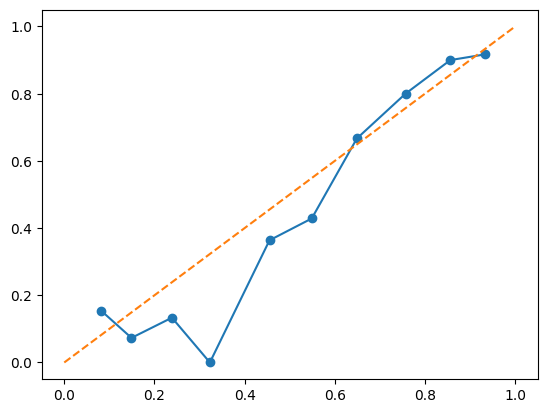

In [31]:
prob_true, prob_pred = calibration_curve(y_test_tree, y_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1], linestyle='--')
plt.show()

### Brier Score

In [32]:
brier_score_loss(y_test_tree, y_proba)

0.13922288149296988

### Expected Calibration Error (ECE)

In [33]:
print(np.abs(prob_true - prob_pred).mean())

0.0907915906898428


## XGBOOST

In [34]:
neg = (y_train_tree == 0).sum()
pos = (y_train_tree == 1).sum()
spw = neg / pos

xgb_exp = ModelExperiment(
    model_name="XGBoost",
    model=XGBClassifier(eval_metric='logloss', random_state=42,tree_method='hist',scale_pos_weight=spw),
    param_grid={
        'learning_rate': [0.001,0.01, 0.05, 0.1],
        'n_estimators': [100,200,300],
        'max_depth': [2,3,4,5],
        'subsample': [0.6,0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.3, 0.5]
    }
)

In [35]:
results = xgb_exp.run_experiment(X_train_tree, y_train_tree, X_test_tree, y_test_tree)

=== XGBoost ===
Fitting 5 folds for each of 3840 candidates, totalling 19200 fits


### Mejores parámetros

In [36]:
xgbmodel = joblib.load('../models/XGBoost_final.pkl')
print(xgbmodel)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)


### Evaluación

### Métricas básicas

In [37]:
xgb_best = joblib.load('../models/XGBoost_final.pkl')

metrics_xgb, y_pred, y_proba, t_tr_xgb, t_inf_xgb = evaluate_model(xgb_best, X_train_tree, y_train_tree, X_test_tree, y_test_tree)

metrics_xgb.T

,0
Accuracy,0.798883
Precision,0.720000
Recall,0.782609
F1-Score,0.750000
ROC-AUC,0.858103
PR-AUC,0.823184
MCC,0.583680
Balanced Accuracy,0.795850


### Métricas por Clase/Grupo

### Confusion Matrix

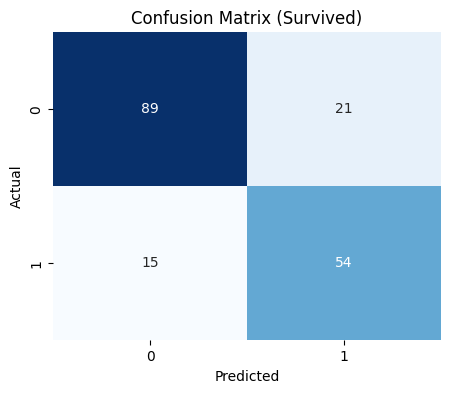

In [38]:
cm = confusion_matrix(y_test_tree, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Survived)')
plt.show()

### Métricas desagregadas por: 

Género

In [39]:
print("Métricas por Género\n(Hombre=0, Mujer=1)")
metrics_by_group(y_test_tree, y_pred, y_proba, X_test_tree['Sex_female'])

Métricas por Género
(Hombre=0, Mujer=1)


,Grupo,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,MCC,Balanced Accuracy
0,0,0.771186,0.44,0.458333,0.448980,0.707890,0.520752,0.304772,0.654699
1,1,0.852459,0.86,0.955556,0.905263,0.848611,0.929465,0.592736,0.759028


Clase socioeconómica

In [40]:
print("Métricas por Clase Socioeconómica")
metrics_by_group(y_test_tree, y_pred, y_proba, X_test['Pclass'])

Métricas por Clase Socioeconómica


,Grupo,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,MCC,Balanced Accuracy
0,1,0.666667,0.666667,0.800000,0.727273,0.784000,0.851728,0.316228,0.650000
1,2,0.911765,0.947368,0.900000,0.923077,0.932143,0.954235,0.821271,0.914286
2,3,0.820000,0.615385,0.666667,0.640000,0.790022,0.673366,0.520997,0.767544


Grupo de Edad

In [41]:
print("Métricas por Grupo de Edad")
metrics_by_group(y_test_tree, y_pred, y_proba, X_test['AgeGroup_ordinal'])

Métricas por Grupo de Edad


,Grupo,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,MCC,Balanced Accuracy
0,1,0.857143,0.800000,1.000000,0.888889,0.854167,0.833879,0.730297,0.833333
1,2,0.916667,0.909091,0.909091,0.909091,0.951049,0.925466,0.832168,0.916084
2,3,0.790476,0.717949,0.717949,0.717949,0.820901,0.793141,0.551282,0.775641
3,4,0.677419,0.500000,0.700000,0.583333,0.814286,0.761927,0.344423,0.683333
4,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Tamaño de familia

In [42]:
print("Métricas por Tamaño de Familia")
metrics_by_group(y_test_tree, y_pred, y_proba, X_test_tree['FamilySize'])

Métricas por Tamaño de Familia


,Grupo,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,MCC,Balanced Accuracy
0,-0.791007,0.796117,0.676471,0.696970,0.686567,0.787013,0.747114,0.535669,0.769913
1,0.836696,0.718750,0.736842,0.777778,0.756757,0.829365,0.880532,0.424871,0.710317
2,1.343027,0.800000,0.714286,0.909091,0.800000,0.941558,0.932771,0.623377,0.811688
3,1.558215,0.857143,0.833333,1.000000,0.909091,0.600000,0.810000,0.645497,0.750000
4,1.729856,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Análisis de calibración

### Calibration plots (reliability diagrams)

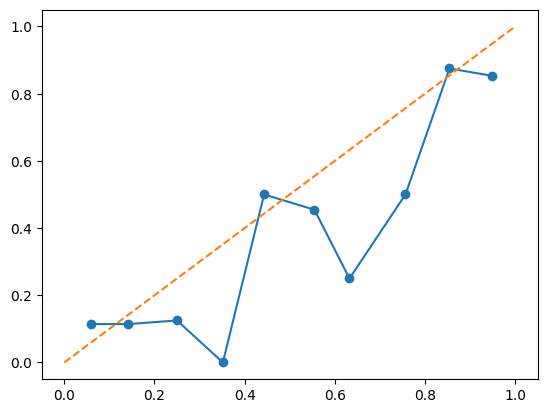

In [43]:
prob_true, prob_pred = calibration_curve(y_test_tree, y_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1], linestyle='--')
plt.show()

### Brier Score

In [44]:
brier_score_loss(y_test_tree, y_proba)

0.1458116957564997

### Expected Calibration Error (ECE)

In [45]:
print(np.abs(prob_true - prob_pred).mean())

0.14730354682878913


## SVM

In [46]:
svm_exp = ModelExperiment(
    model_name="SVM",
    model=SVC(probability=True, random_state=42),
    param_grid={
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf','sigmoid','poly'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'degree': [2,3,4]
    }
)

In [ ]:
svm_exp.run_experiment(X_train_svm, y_train_svm, X_test_svm, y_test_svm)

### Mejores parámetros

In [48]:
svmmodel = joblib.load('../models/SVM_final.pkl')
print(svmmodel)

SVC(C=10, degree=2, probability=True, random_state=42)


### Evaluación

### Métricas básicas

In [49]:
svm_best = joblib.load('../models/SVM_final.pkl')

metrics_svm, y_pred, y_proba, t_tr_svm, t_inf_svm = evaluate_model(svm_best, X_train_svm, y_train_svm, X_test_svm, y_test_svm)

metrics_svm.T

,0
Accuracy,0.614525
Precision,0.000000
Recall,0.000000
F1-Score,0.000000
ROC-AUC,0.746179
PR-AUC,0.657758
MCC,0.000000
Balanced Accuracy,0.500000


### Métricas por Clase/Grupo

### Confusion Matrix

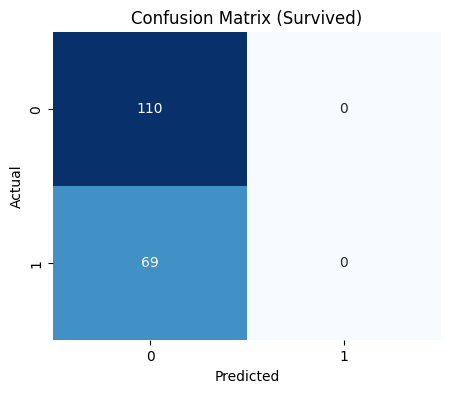

In [50]:
cm = confusion_matrix(y_test_svm, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Survived)')
plt.show()

### Métricas desagregadas por: 

Género

In [51]:
print("Métricas por Género\n(Hombre=0, Mujer=1)")
metrics_by_group(y_test_svm, y_pred, y_proba, X_test_svm['Sex_female'])

Métricas por Género
(Hombre=0, Mujer=1)


,Grupo,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,MCC,Balanced Accuracy
0,0,0.796610,0.0,0.0,0.0,0.690603,0.447272,0.0,0.5
1,1,0.262295,0.0,0.0,0.0,0.669444,0.847711,0.0,0.5


Clase socioeconómica

In [52]:
print("Métricas por Clase Socioeconómica")
metrics_by_group(y_test_svm, y_pred, y_proba, X_test['Pclass'])

Métricas por Clase Socioeconómica


,Grupo,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,MCC,Balanced Accuracy
0,1,0.444444,0.0,0.0,0.0,0.732000,0.799415,0.0,0.5
1,2,0.411765,0.0,0.0,0.0,0.735714,0.822482,0.0,0.5
2,3,0.760000,0.0,0.0,0.0,0.702029,0.373290,0.0,0.5


Grupo de Edad

In [53]:
print("Métricas por Grupo de Edad")
metrics_by_group(y_test_svm, y_pred, y_proba, X_test['AgeGroup_ordinal'])

Métricas por Grupo de Edad


,Grupo,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,MCC,Balanced Accuracy
0,1,0.428571,0.0,0.0,0.0,0.500000,0.605979,0.0,0.5
1,2,0.541667,0.0,0.0,0.0,0.671329,0.681581,0.0,0.5
2,3,0.628571,0.0,0.0,0.0,0.800699,0.717998,0.0,0.5
3,4,0.677419,0.0,0.0,0.0,0.823810,0.748124,0.0,0.5
4,5,0.800000,0.0,0.0,0.0,1.000000,1.000000,0.0,0.5


Tamaño de familia

In [54]:
print("Métricas por Tamaño de Familia\n")
metrics_by_group(y_test_svm, y_pred, y_proba, X_test_svm['FamilySize'])

Métricas por Tamaño de Familia



,Grupo,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,MCC,Balanced Accuracy
0,-0.791007,0.679612,0.0,0.0,0.0,0.754978,0.617029,0.0,0.5
1,0.836696,0.437500,0.0,0.0,0.0,0.819444,0.864914,0.0,0.5
2,1.343027,0.560000,0.0,0.0,0.0,0.603896,0.508473,0.0,0.5
3,1.558215,0.285714,0.0,0.0,0.0,0.400000,0.759524,0.0,0.5
4,1.729856,0.666667,0.0,0.0,0.0,0.750000,0.750000,0.0,0.5


### Análisis de Calibración

### Calibration plots (reliability diagrams)

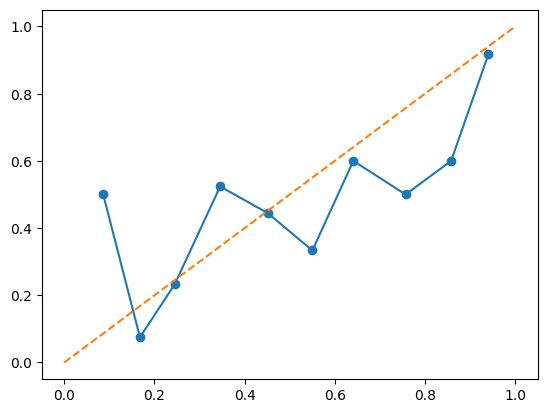

In [55]:
prob_true, prob_pred = calibration_curve(y_test_svm, y_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1], linestyle='--')
plt.show()

### Brier Score

In [56]:
brier_score_loss(y_test_svm, y_proba)

0.20491642059115597

### Expected Calibration Error (ECE)

In [57]:
print(np.abs(prob_true - prob_pred).mean())

0.15000648041846323


## Comparación de modelos

### Tabla comparativa

In [58]:
comp_mods = pd.concat([metrics_log, metrics_rf, metrics_xgb, metrics_svm]).reset_index()
comp_mods.drop(columns=['index'], inplace=True)
comp_mods.insert(0, 'Modelo', ['Regresión Logística', 'Random Forest', 'XGBoost', 'SVM'])
comp_mods.insert(9, 'Tiempo Training', [t_tr_log, t_tr_rf, t_tr_xgb, t_tr_svm])
comp_mods.insert(10, 'Tiempo Inference', [t_inf_log, t_inf_rf, t_inf_xgb, t_inf_svm])

In [59]:
comp_mods

,Modelo,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,MCC,Balanced Accuracy,Tiempo Training,Tiempo Inference
0,Regresión Logística,0.798883,0.708861,0.811594,0.756757,0.863900,0.790420,0.590564,0.801252,0.078243,0.004628
1,Random Forest,0.810056,0.727273,0.811594,0.767123,0.862187,0.832137,0.610164,0.810343,0.648192,0.045778
2,XGBoost,0.798883,0.720000,0.782609,0.750000,0.858103,0.823184,0.583680,0.795850,0.293573,0.014526
3,SVM,0.614525,0.000000,0.000000,0.000000,0.746179,0.657758,0.000000,0.500000,0.238800,0.072284


### Análisis estadístico

### Test de significancia entre modelos (McNemar's test)

Como los modelos Logistic Regression y SVM fueron evaluados sobre un mismo set de test mientras que Random Forest y XGBoost sobre otro, se realizarán unicamente dos tests de significancia entre modelos que comparen entre aquellos que coinciden en el set con el que fueron evaluados porque McNemar requiere comparar errores sobre los mismos ejemplos.

Lo que se busca obtener mediante el McNemar's test en este caso es evidencia estadística que permita determinar si existe una diferencia estadísticamente significativa en el rendimeinto de los dos modelos, siendo el criterio basado en el valor p

p < 0.05 : existe una diferencia significativa en el rendimiento de los dos modelos

p > 0.05 : no hay evidencia estadística suficiente de que exista una diferencia

In [60]:
def run_mcnemar(y_true, pred1, pred2, name1, name2):
    both_correct = ((pred1 == y_true) & (pred2 == y_true)).sum()
    model1_correct_only = ((pred1 == y_true) & (pred2 != y_true)).sum()
    model2_correct_only = ((pred1 != y_true) & (pred2 == y_true)).sum()
    both_wrong = ((pred1 != y_true) & (pred2 != y_true)).sum()

    contingency = [[both_correct, model1_correct_only],
                   [model2_correct_only, both_wrong]]

    result = mcnemar(contingency, exact=False, correction=True)

    return {
        'Modelo A': name1,
        'Modelo B': name2,
        'Chi2': result.statistic,
        'p-value': result.pvalue
    }

In [61]:
log_pred = log_best.predict(X_test_svm)
svm_pred = svm_best.predict(X_test_svm)

rf_pred = rf_best.predict(X_test_tree)
xgb_pred = xgb_best.predict(X_test_tree)

#McNemar tests
results = []

#Logistic vs SVM (mismo dataset: test_svm)
results.append(run_mcnemar(y_test_svm, log_pred, svm_pred, 'LogisticRegresssion', 'SVM'))

#RandomForest vs XGBoost (mismo dataset: test_tree)
results.append(run_mcnemar(y_test_tree, rf_pred, xgb_pred, 'RandomForest', 'XGBoost'))

df_results = pd.DataFrame(results)
df_results

,Modelo A,Modelo B,Chi2,p-value
0,LogisticRegresssion,SVM,12.962025,0.000318
1,RandomForest,XGBoost,0.071429,0.789268


Se concluye que sí hay evidencia estadística suficiente que muestra diferencias significativas en el rendimiento entre LogisticRegression y SVM, mientras que el caso contrario se presenta entre RandomForest y XGBoost donde no hay evidencia de que un modelo sea significativamente mejor que el otro.

### Intervalos de confianza para métricas

Con nivel de confianza de 95%

In [62]:
log_proba = log_best.predict_proba(X_test_svm)[:, 1]
svm_proba = svm_best.predict_proba(X_test_svm)[:, 1]

rf_proba = rf_best.predict_proba(X_test_tree)[:, 1]
xgb_proba = xgb_best.predict_proba(X_test_tree)[:, 1]

In [63]:
#Intervalos de confianza para métricas
def metr_ic(y_test, y_pred, y_proba, n_bootstrap=1000, alpha=0.05):
    """
    Calcula intervalos de confianza para métricas de clasificación.
    """
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)

    rng = np.random.default_rng(42)  # reproducibilidad
    metricsic = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1-Score": [],
        "ROC-AUC": [],
        "PR-AUC": [],
        "MCC": [],
        "Balanced Accuracy": []
    }

    n = len(y_test)
    for _ in range(n_bootstrap):
        idx = rng.choice(n, size=n, replace=True)
        y_res = y_test[idx]
        p_res = y_pred[idx]
        prob_res = y_proba[idx]

        metricsic["Accuracy"].append(accuracy_score(y_res, p_res))
        metricsic["Precision"].append(precision_score(y_res, p_res, zero_division=0))
        metricsic["Recall"].append(recall_score(y_res, p_res, zero_division=0))
        metricsic["F1-Score"].append(f1_score(y_res, p_res, zero_division=0))
        metricsic["ROC-AUC"].append(roc_auc_score(y_res, prob_res))
        metricsic["PR-AUC"].append(average_precision_score(y_res, prob_res))
        metricsic["MCC"].append(matthews_corrcoef(y_res, p_res))
        metricsic["Balanced Accuracy"].append(balanced_accuracy_score(y_res, p_res))

    #percentiles para IC
    metrics_ci = {}
    for metric, values in metricsic.items():
        lower = np.percentile(values, 100 * alpha/2)
        upper = np.percentile(values, 100 * (1 - alpha/2))
        metrics_ci[metric] = (lower, upper)

    return metrics_ci

In [64]:
#aplicando a cada modelo 
ci_log = metr_ic(y_test_svm, log_pred, log_proba)
ci_rf = metr_ic(y_test_tree, rf_pred, rf_proba)
ci_xgb = metr_ic(y_test_tree, xgb_pred, xgb_proba)
ci_svm = metr_ic(y_test_svm, svm_pred, svm_proba)

In [65]:
#Convertir a DataFrame
def ci_to_df(ci_dict):
    filas = [
        {"Métrica": met, "Lim Inf": low, "Lim Sup": high}
        for met, (low, high) in ci_dict.items()
    ]
    return pd.DataFrame(filas)

In [66]:
print('Intervalos de confianza para métricas - LogisticRegression')
ci_to_df(ci_log)

Intervalos de confianza para métricas - LogisticRegression


,Métrica,Lim Inf,Lim Sup
0,Accuracy,0.737430,0.854749
1,Precision,0.602941,0.812517
2,Recall,0.714286,0.896137
3,F1-Score,0.671329,0.827171
4,ROC-AUC,0.800865,0.917809
5,PR-AUC,0.681795,0.892816
6,MCC,0.460970,0.703622
7,Balanced Accuracy,0.735053,0.857200


In [67]:
print('Intervalos de confianza para métricas - Random Forest')
ci_to_df(ci_rf)

Intervalos de confianza para métricas - Random Forest


,Métrica,Lim Inf,Lim Sup
0,Accuracy,0.748464,0.865922
1,Precision,0.612482,0.828998
2,Recall,0.710517,0.904142
3,F1-Score,0.680542,0.838333
4,ROC-AUC,0.794228,0.919703
5,PR-AUC,0.739063,0.906837
6,MCC,0.478527,0.725865
7,Balanced Accuracy,0.744856,0.866924


In [68]:
print('Intervalos de confianza para métricas - XGBoost')
ci_to_df(ci_xgb)

Intervalos de confianza para métricas - XGBoost


,Métrica,Lim Inf,Lim Sup
0,Accuracy,0.737430,0.854749
1,Precision,0.609730,0.811594
2,Recall,0.686526,0.876923
3,F1-Score,0.662252,0.818209
4,ROC-AUC,0.792137,0.914074
5,PR-AUC,0.731933,0.896384
6,MCC,0.457616,0.695041
7,Balanced Accuracy,0.731836,0.851870


In [69]:
print('Intervalos de confianza para métricas - SVM')
ci_to_df(ci_svm)

Intervalos de confianza para métricas - SVM


,Métrica,Lim Inf,Lim Sup
0,Accuracy,0.541899,0.687151
1,Precision,0.000000,0.000000
2,Recall,0.000000,0.000000
3,F1-Score,0.000000,0.000000
4,ROC-AUC,0.668047,0.815576
5,PR-AUC,0.538932,0.765084
6,MCC,0.000000,0.000000
7,Balanced Accuracy,0.500000,0.500000


### Análisis de varianzas entre folds de CV

In [70]:
X_svm = df_num.drop(columns=drop_svm + ['Survived'])
y_svm = df['Survived']
X_tree = df_num.drop(columns=drop_tree + ['Survived'])
y_tree = df['Survived']

In [71]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models1 = {
    'Logistic Regression': log_best,
    'SVM': svm_best
}

scores = {}
for name, model in models1.items():
    cv_scores = cross_val_score(model, X_svm, y_svm, cv=cv, scoring=make_scorer(f1_score))
    scores[name] = cv_scores
    print(f'{name}: {cv_scores} -> mean={cv_scores.mean():.3f}')

#ANOVA 
f_stat, p_value = f_oneway(*scores.values())
print('\nANOVA results')
print('F-statistic:', f_stat)
print('p-value:', p_value)

df_scores = pd.DataFrame(scores)
print('\nScores por fold:')
df_scores

Logistic Regression: [0.75177305 0.78873239 0.74820144 0.75177305 0.78571429] -> mean=0.765
SVM: [0. 0. 0. 0. 0.] -> mean=0.000

ANOVA results
F-statistic: 7211.176969129804
p-value: 4.1253411407743384e-13

Scores por fold:


,Logistic Regression,SVM
0,0.751773,0.0
1,0.788732,0.0
2,0.748201,0.0
3,0.751773,0.0
4,0.785714,0.0


In [72]:
models2 = {
    'Random Forest': rf_best,
    'XGBoost': xgb_best,
}

scores = {}
for name, model in models2.items():
    cv_scores = cross_val_score(model, X_tree, y_tree, cv=cv, scoring=make_scorer(f1_score))
    scores[name] = cv_scores
    print(f'{name}: {cv_scores} -> mean={cv_scores.mean():.3f}')

#ANOVA 
f_stat, p_value = f_oneway(*scores.values())
print('\nANOVA results')
print('F-statistic:', f_stat)
print('p-value:', p_value)

df_scores = pd.DataFrame(scores)
print('\nScores por fold:')
df_scores

Random Forest: [0.8057554  0.79166667 0.77372263 0.74452555 0.80851064] -> mean=0.785
XGBoost: [0.79411765 0.79166667 0.71111111 0.7761194  0.78518519] -> mean=0.772

ANOVA results
F-statistic: 0.4602709403948138
p-value: 0.5166377491816205

Scores por fold:


,Random Forest,XGBoost
0,0.805755,0.794118
1,0.791667,0.791667
2,0.773723,0.711111
3,0.744526,0.776119
4,0.808511,0.785185


Al igual que el test de significancia entre modelos, el análisis de varianzas entre el cross validation score de los folds también indica que hay una diferencia significativa entre los modelos Logistic Regression y SVM en cuanto a desempeño (pvalue < 0.05), mientras que ocurre el caso contrario entre Random Forest y XGBosst (pvalue > 0.05). 

### Visualizaciones comparativas

Curvas ROC superpuestas

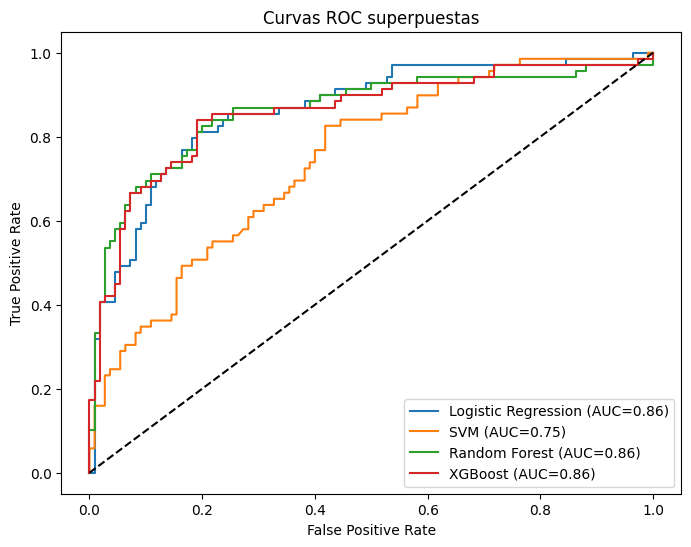

In [73]:
plt.figure(figsize=(8,6))

for nombre, (y_test, y_proba) in {
    "Logistic Regression": (y_test_svm, log_proba),
    "SVM": (y_test_svm, svm_proba),
    "Random Forest": (y_test_tree, rf_proba),
    "XGBoost": (y_test_tree, xgb_proba)
}.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{nombre} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC superpuestas")
plt.legend()
plt.show()

Curvas Precision-Recall

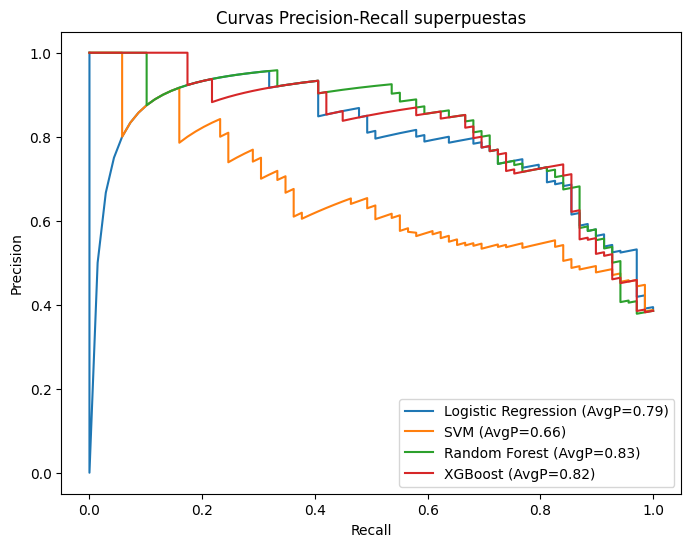

In [74]:
plt.figure(figsize=(8,6))

for nombre, (y_test, y_proba) in {
    "Logistic Regression": (y_test_svm, log_proba),
    "SVM": (y_test_svm, svm_proba),
    "Random Forest": (y_test_tree, rf_proba),
    "XGBoost": (y_test_tree, xgb_proba)
}.items():
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    plt.plot(recall, precision, label=f"{nombre} (AvgP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas Precision-Recall superpuestas")
plt.legend()
plt.show()

Box plots de métricas por fold

In [75]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'roc_auc': 'roc_auc',
    #'pr_auc': make_scorer(average_precision_score, needs_threshold=True),
    'mcc': make_scorer(matthews_corrcoef),
    'balanced_accuracy': make_scorer(balanced_accuracy_score)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_results(model, X, y, model_name):
    results = cross_validate(
        model,
        X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=False
    )
    df_folds = pd.DataFrame(results)
    df_folds["Fold"] = range(1, len(df_folds)+1)
    df_folds["Modelo"] = model_name
    return df_folds

cv_log = cv_results(log_best, X_svm, y_svm, "Logistic Regression")
cv_rf  = cv_results(rf_best, X_tree, y_tree, "Random Forest")
cv_xgb = cv_results(svm_best, X_tree, y_tree, "XGBoost")
cv_svm = cv_results(svm_best, X_svm, y_svm, "SVM")

df_cv = pd.concat([cv_log, cv_rf, cv_xgb, cv_svm], ignore_index=True)

In [76]:
df_cv

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_mcc,test_balanced_accuracy,Fold,Modelo
0,0.068886,0.025377,0.804469,0.736111,0.768116,0.751773,0.852042,0.590967,0.797694,1,Logistic Regression
1,0.101212,0.054906,0.831461,0.756757,0.823529,0.788732,0.858422,0.650567,0.829947,2,Logistic Regression
2,0.069554,0.012198,0.803371,0.732394,0.764706,0.748201,0.840107,0.587402,0.795989,3,Logistic Regression
3,0.032793,0.013116,0.803371,0.726027,0.779412,0.751773,0.843449,0.590338,0.798797,4,Logistic Regression
4,0.067174,0.010602,0.831461,0.774648,0.797101,0.785714,0.868502,0.647051,0.825156,5,Logistic Regression
5,0.333594,0.032089,0.849162,0.800000,0.811594,0.805755,0.911397,0.682525,0.842161,1,Random Forest
6,0.333621,0.031630,0.831461,0.750000,0.838235,0.791667,0.888703,0.653728,0.832754,2,Random Forest
7,0.320252,0.033269,0.825843,0.768116,0.779412,0.773723,0.863503,0.632227,0.816979,3,Random Forest
8,0.355119,0.040618,0.803371,0.739130,0.750000,0.744526,0.866979,0.584763,0.793182,4,Random Forest
9,0.347677,0.033278,0.848315,0.791667,0.826087,0.808511,0.897221,0.683447,0.844236,5,Random Forest


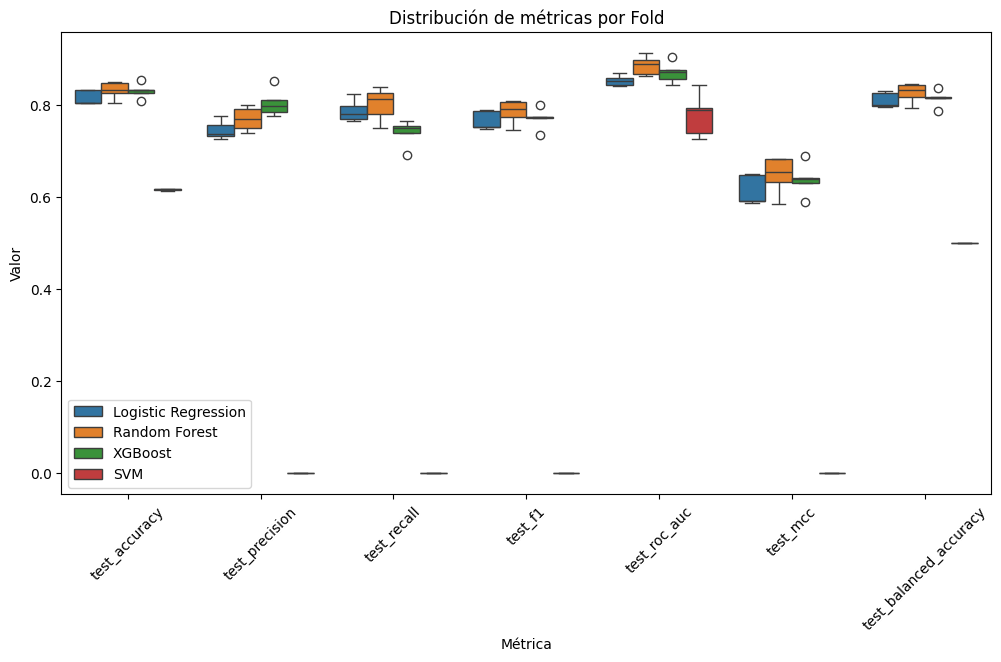

In [77]:
df_long = df_cv.melt(
    id_vars=["Modelo","Fold"], 
    value_vars=["test_accuracy", "test_precision", "test_recall", "test_f1", "test_roc_auc", "test_mcc", "test_balanced_accuracy"],
    var_name="Métrica", 
    value_name="Valor"
)

plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_long,
    x="Métrica", y="Valor", hue="Modelo"
)

plt.title("Distribución de métricas por Fold")
plt.xticks(rotation=45)
plt.legend(loc="lower left")
plt.show()

Sin Métricas = 0 para todos los folds de SVM

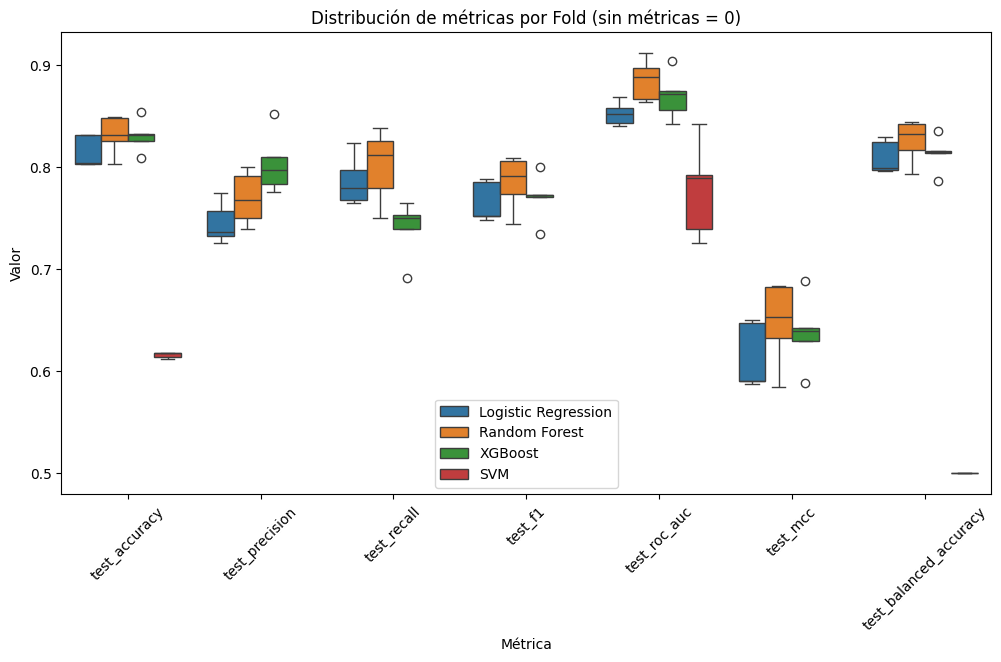

In [78]:
#quitar métricas cuyo valor es 0 en todos los folds
df_long2 = df_long.dropna(subset=["Valor"]).copy()

mask = df_long2.groupby(["Métrica","Modelo"])["Valor"].transform(lambda x: (x != 0).any())
df_plot = df_long2[mask]

plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_plot,
    x="Métrica", y="Valor", hue="Modelo"
)
plt.title("Distribución de métricas por Fold (sin métricas = 0)")
plt.xticks(rotation=45)
plt.legend(loc="lower center")
plt.show()

Radar charts de múltiples métricas

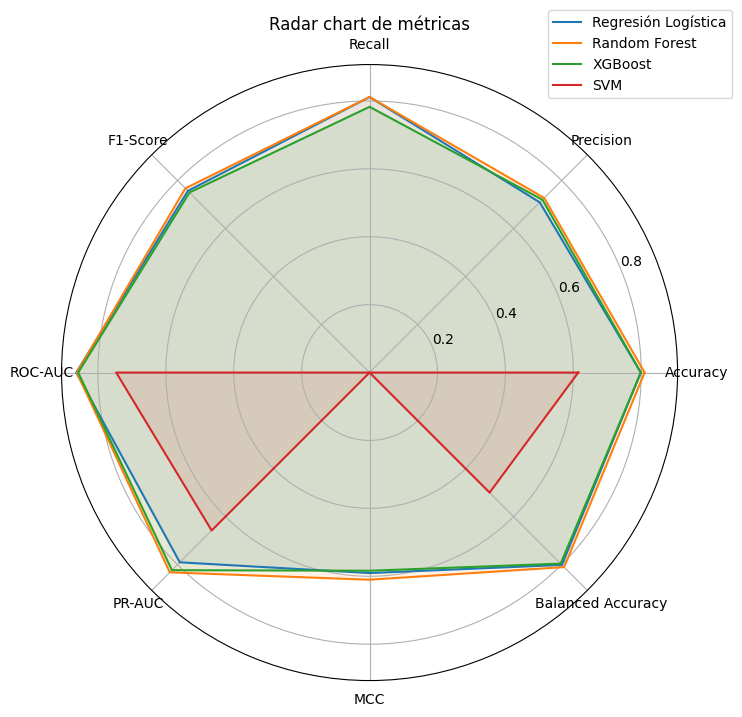

In [79]:
#radar chart
metrics = list(comp_mods.columns[1:-2])
N = len(metrics)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(8,8))

for i, row in comp_mods.iterrows():
    values = row[1:-2].tolist()
    values += values[:1]
    plt.polar(angles, values, label=row["Modelo"])
    plt.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], metrics)
plt.title("Radar chart de métricas")
plt.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
plt.show()